# Описание проекта

Проект реализован для интернет-магазина «Игрок», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Данные предоставлены до 2016 года. Уловно, сейчас декабрь 2016 г., нужно спланировать кампанию на 2017-й.

*В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».*

## Подготовка данных

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy import stats as st

import warnings

warnings.filterwarnings('ignore')

In [6]:
try:
    games = pd.read_csv('games.csv')
except:
    games = pd.read_csv('/datasets/games.csv')

In [7]:
games.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [8]:
games.columns = games.columns.str.lower()
list(games.columns)

['name',
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critic_score',
 'user_score',
 'rating']

Приводим название колонок к удобному формату(нижний регистор)

In [9]:
games.info()  # show info about all DF

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Мы можем наблюдать, что в колонках 0, 2, 3, 8, 9 есть пропуски. Нужно с ними разобраться.

### Заполнение пропусков

Заполнение пропусков начнем со столбцов `name` и `year_release`

In [10]:
games = games[games['name'].notna()]

Убираем из датафрейма две строки. В этих строках нет жанра и платформы. Такие данные, очень сложно восстановить и всего две строчки не повлияют на результат.

In [11]:
games = games[~games['year_of_release'].isna()]

Так как, пропусков в колонке year_of_release меньше 2%, можно удалить строки с пропусками и это не сильно повлияет на качество конечного результата.

Пропуски в колонке `year_release` могли появиться из-за того, что в базу данных сайта не занесен год для конкретной игры и платформы. В основном игры на старые консоли и им могли не уделить должного внимания.

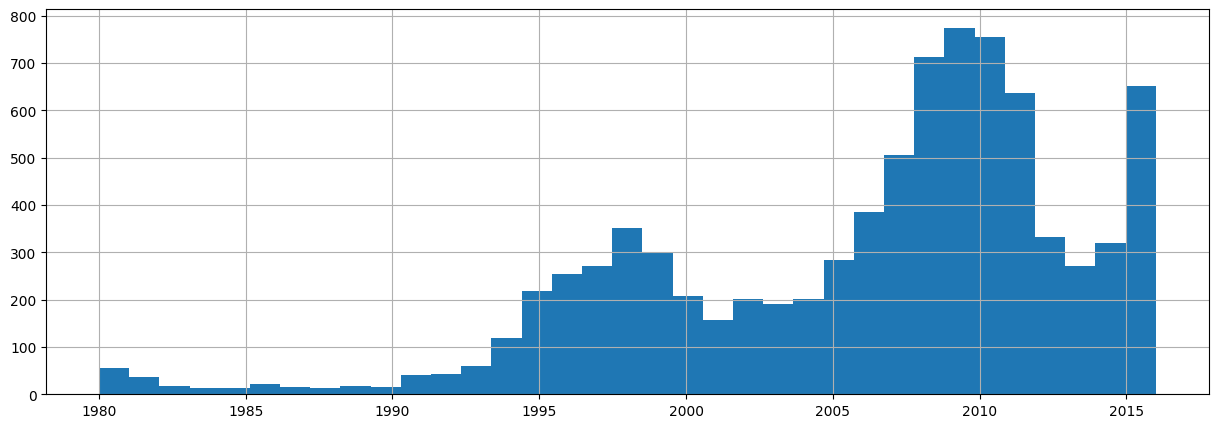

In [12]:
# show hist for column year_of_release
games[games['critic_score'].isna()]['year_of_release'].hist(bins=35, figsize=(15, 5));

Изучая пропуски в колонке `critic_score` по годам, можно наблюдать резкий выброс отсутствия оценок в 2008-2011 годах. Есть у меня предположение, что это связанно с ростом кол-ва выпускаемых игр в эти года. Либо, это как-то связанно с внутренними особенностями работы сайты в этот период времени.

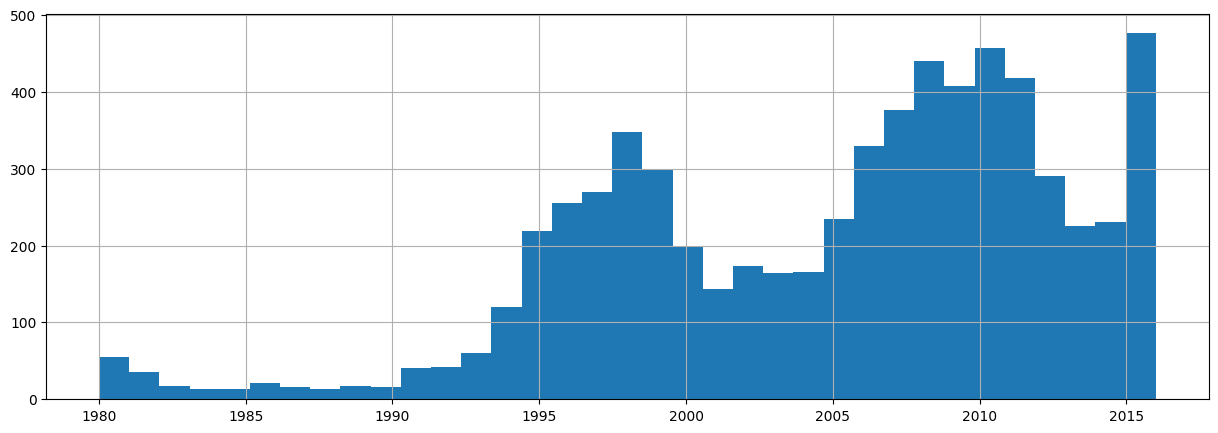

In [13]:
games[games['user_score'].isna()]['year_of_release'].hist(bins=35, figsize=(15, 5));
# show hist for column year_of_release

На гистограмме для оценки пользователей мы наблюдаем такую же картину. В этом есть закономерность и причина пропусков, должны быть одинаковы в обоих случаях

In [14]:
games['critic_score'] = games['critic_score'].fillna(
    games.groupby(['name', 'platform'])['critic_score']
    .transform('median')
)  # fill NaN with median

games['critic_score'] = games['critic_score'] / 10
# change range for column critic_score

Пропуски, которые мы можем заполнить в колонке `critic_score`, заполняем мединой оценкой по названию игры и типу платформы. Также, делим оценки критиков на 10, чтобы получить единую цену деления для системы оценивания, с колонкой user_score.

In [15]:
games['user_score'] = (
    games['user_score']
    .replace('tbd', np.nan)
    .astype(float)
)

# fill column user_score with median
games['user_score'] = games['user_score'].fillna(
    games.groupby(['name', 'platform'])['user_score']
    .transform('median')
)

В колонке `user_score` пропуски, которые мы можем заполнить, так же, заполняем мединой оценкой по названию игры и типу платформы. И еще `tbd` (без оценки), заполняем значениями `NaN`.


In [16]:
games['year_of_release'] = games['year_of_release'].fillna(0).astype(int)
games['critic_score'] = games['critic_score'].fillna(0).astype(int)

Заполняем пропуски нулем и меняем тип данных на целочисленные в столбцах `year_of_release` и `critic_score`. Так как, в данных столбцах не встречается значений со знаком после запятой.

In [17]:
# create new column - total_sales
games['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

Добавляем новую колонку `total_sales`. Она будет в себе содержать сумму проданных копий со всех рынков (na, eu, jp, other).

## Исследовательский анализ данных

В этом блоке мы изучим закономерности, корреляции в данных и подкрепим все это выводами и гипотезами.

<Axes: >

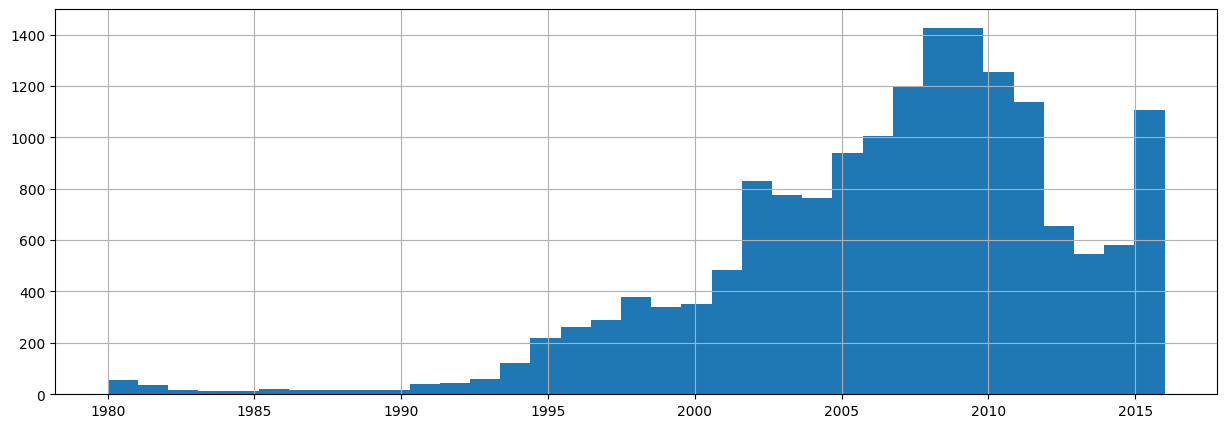

In [18]:
# show hist for year_of_release
games['year_of_release'].hist(bins=35, figsize=(15, 5))

На гистограмме, мы можем наблюдать, что до 1990 годов выпускалось очень маленькое коло-во игр. Поэтому для нашего исследования эти данные можно отбросить.

In [19]:
games = games[games['year_of_release'] > 1990]
# drop rows with year_of_release older then 1990

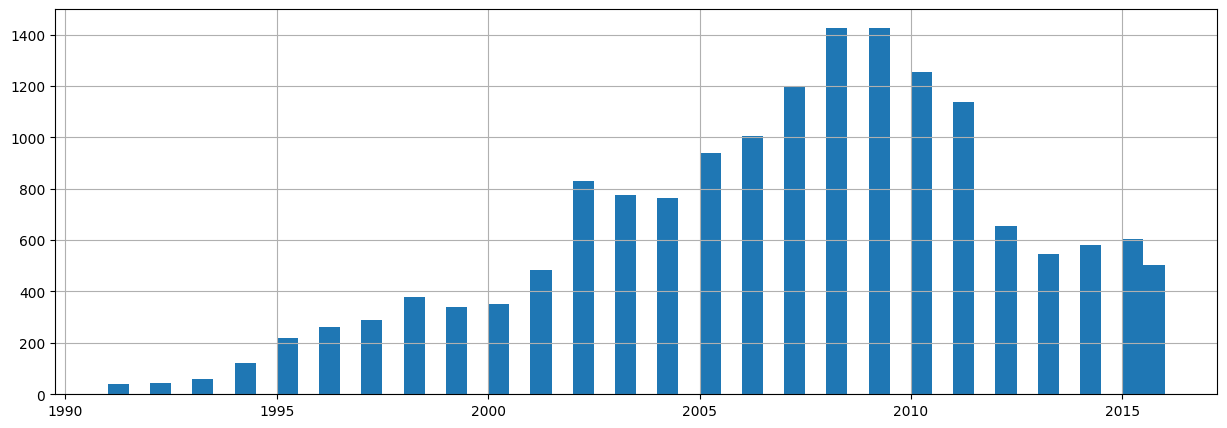

In [20]:
games['year_of_release'].hist(bins=50, figsize=(15, 5));
# show hist for year_of_release

На диаграмме можно наблюдать, что до 2002 года игровой рынок плавно рос, без сильных выбросов. Далее мы видим, что в период с 2002 по 2011 года выпускалось наибольшее кло-во игр за год.  После 2011 года кол-во выпускаемых игр резко сократилось и в последующих годах, показатели были примерно на одном уровне. Есть предположение, что резкий рост был связан с сильными экономическом подъемом, а впоследствии кризисом 2008-ого года, который сыграл свою роль. Финансирование и кол-во выпускаемых игр сильно сократилось. 2010 и 2011 выпускалось еще много игр, потому что они уже были в разработке и деньги на них были. Последующие года стали более бережливые и умеренные к разработке новых продуктов игровой индустрии.

In [22]:
# crate pivot table by column platform with sum of total_sales
platform_pivot = (
    games.pivot_table(index='platform',
                      values='total_sales',
                      aggfunc='sum')
    .sort_values(ascending=False, by='total_sales')
)

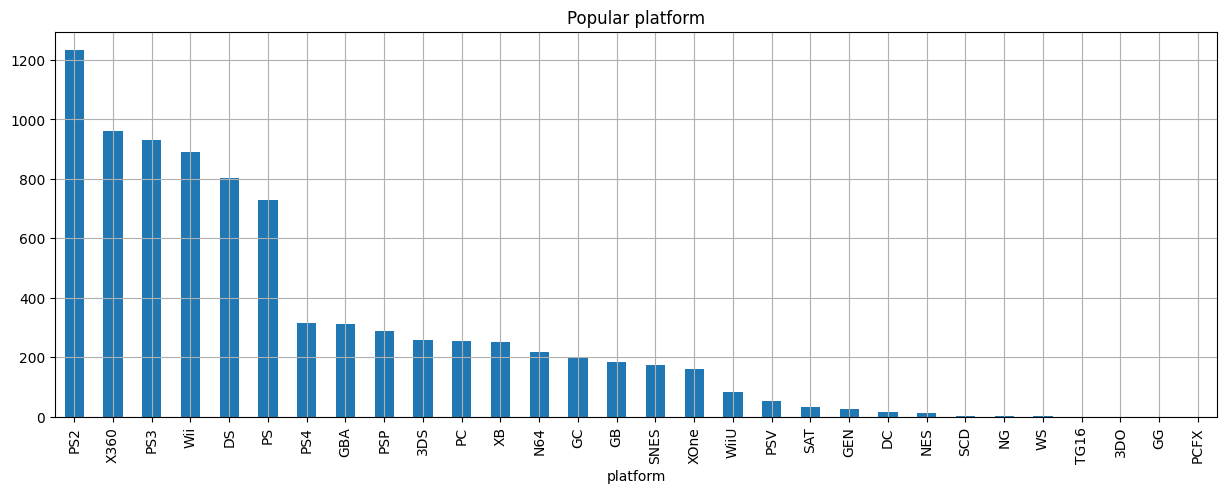

In [23]:
# show bar plot for platform_pivot
platform_pivot.plot(
    kind='bar', figsize=(15, 5), grid=True, legend=False, title='Popular platform');

Составим топ самым популярных платформ по кол-ву проданных игр, для них соответственно. Лидирующие позиции занимают консоли sony, xbox и nintendo.

In [19]:
platform_pivot = platform_pivot.query('total_sales > 300')
platform_pivot  # show most popular platform ever

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88


Чтобы последующие графики и данные были более наглядными, отбросим платформы на которых меньше 300 млн продаж.

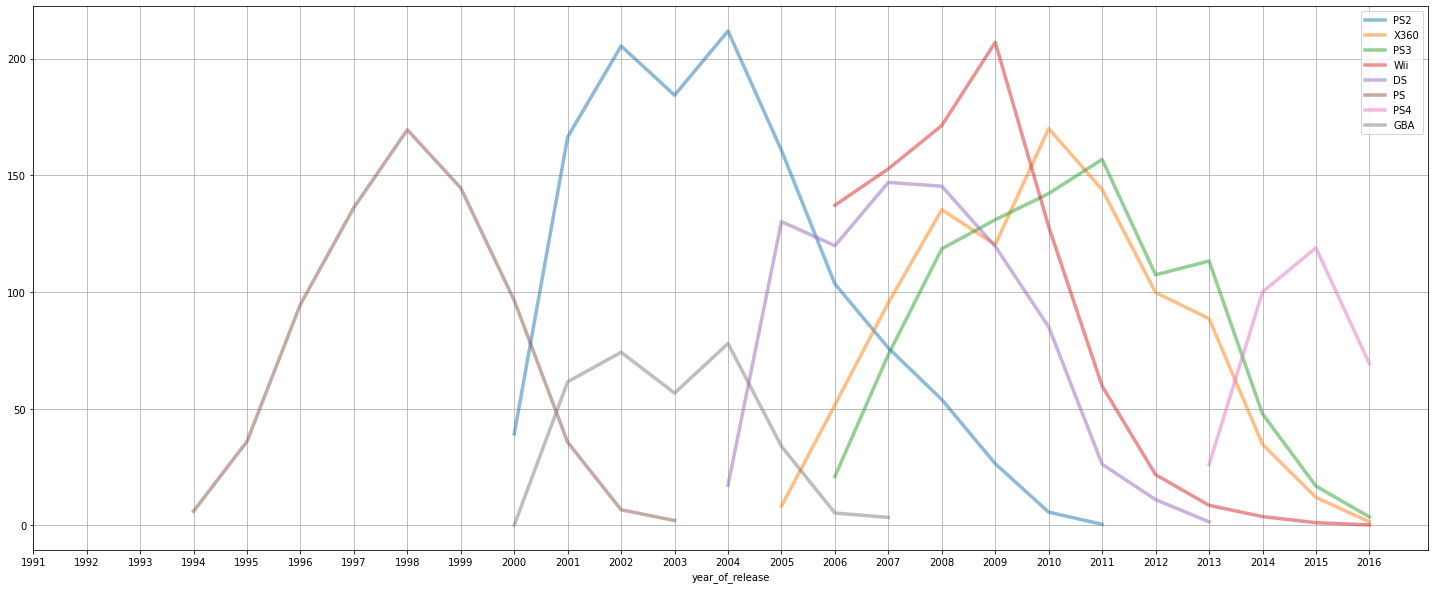

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

for platform in platform_pivot.index:
    (
        (games[games['platform'] == platform])
        .groupby('year_of_release')
        ['total_sales'].sum()
        .plot(x='year_of_release',
              y='total_sales',
              figsize=(25, 10),
              alpha=0.5,
              label=platform,
              legend=True,
              linewidth=3.5,
              grid=True)
    )  # create lines (popularity of platform) by years

# set your ticks manually
ax.xaxis.set_ticks(games['year_of_release'].unique())

plt.show()  # show diagram

На диаграмме мы можем наблюдать, что средний срок жизни консоли 10 лет. У Xbox и PS(кроме PS1) показатель стабильный и равен 11 годам. И видно, что продажи на этих консолях имеют распределение близкое к нормальному, в отличие от других платформ.

## Исследование, для составления прогноза на 2017 год

Для дальнейших наблюдений, возьмем данный за 2014 год - 2016 год. Это наиболее актуальная и полная выборка. Если взять выборку за 2016 год, то результаты исследования могут исказиться из-за того, что данные 2016 года неполные (год еще не закончился).

In [21]:
games_2015 = games.query('year_of_release >= 2014').copy()
# create new DF with data for 2015

In [22]:
games_2015.head()  # show 5 rows

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,9,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,0,NaN,NaN,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,8,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,0,NaN,NaN,7.98


### Начнем исследование с изучения показателей продаж относительно платформы

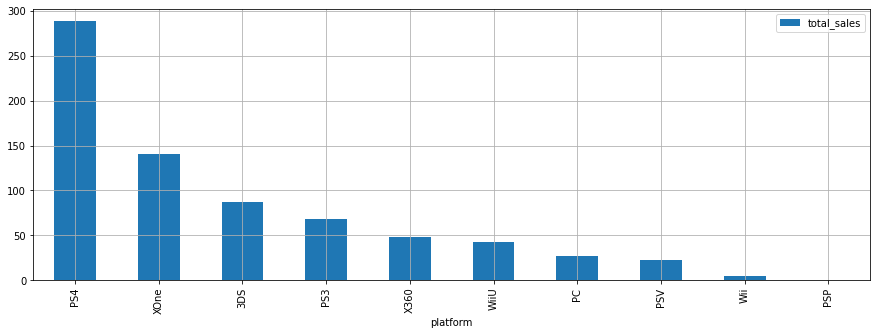

In [23]:
(
    games_2015.pivot_table(
        index='platform',
        values='total_sales',
        aggfunc='sum'
    )
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar', figsize=(15, 5), grid=True)
);  # show rating of most popular platforms

Самой прибыльной платформной, является ps4. Показатель общих продаж в два раза больше, чем у ближайшего конкурента (XOne). Остальные платформы принесут в разы меньше прибыли, чем PS4 и Xbox One. Поэтому, можно считать, что самые потенциально прибыльные платформы это - `PS4` и `Xbox One`.

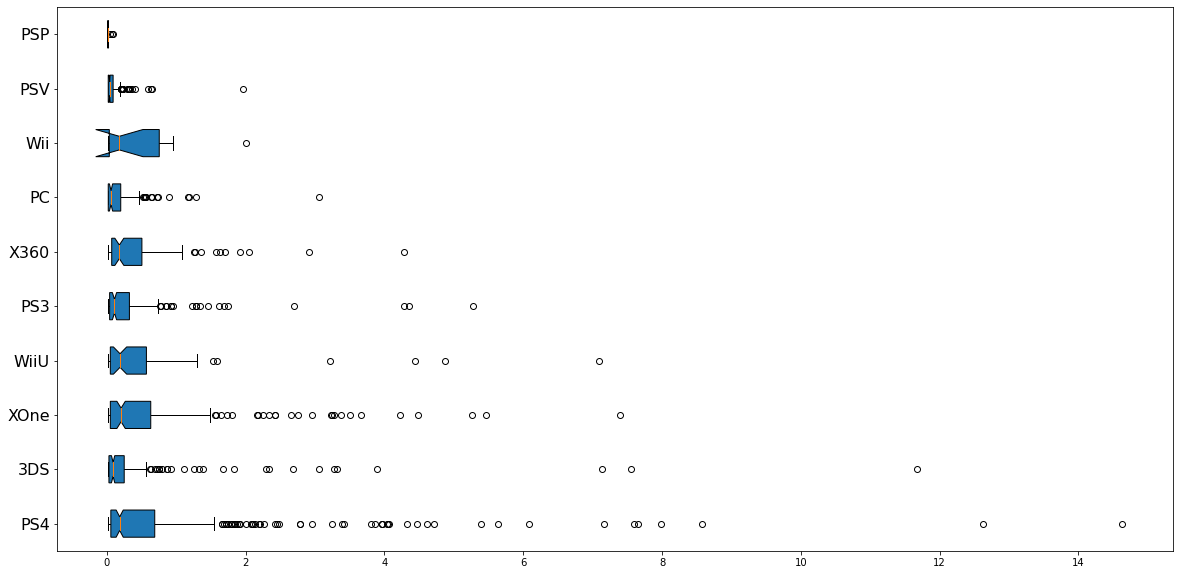

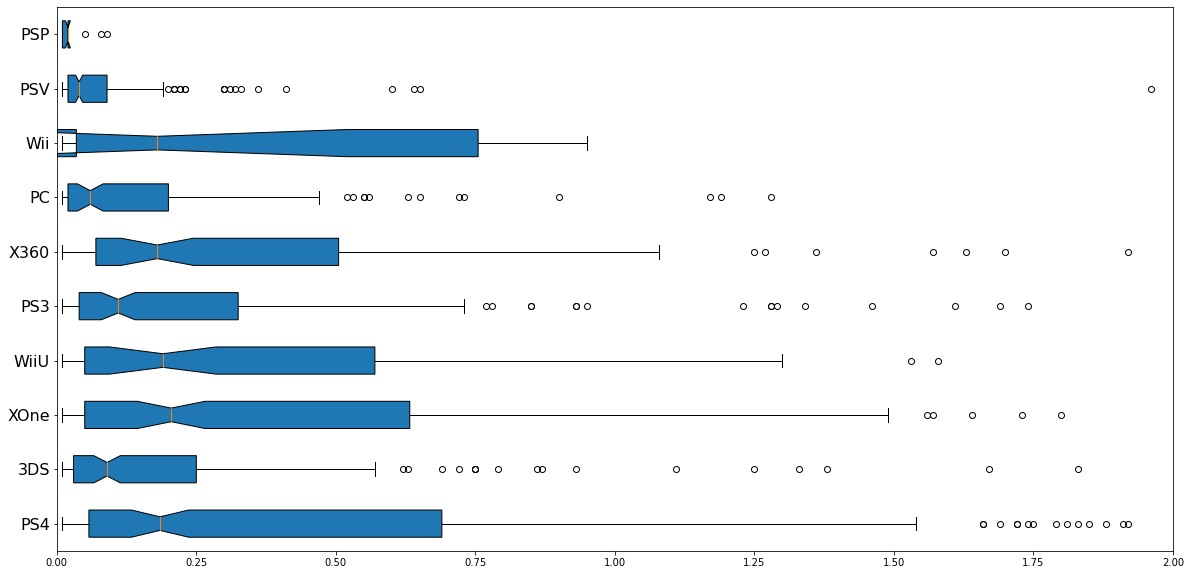

In [24]:
#  show box plot for all platforms

data = []
for platform in games_2015['platform'].unique():
    data.append(
        list(games_2015.loc[games_2015['platform'] == platform, 'total_sales'])
    )

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

# Creating axes instance
bp = ax.boxplot(data, patch_artist=True,
                notch='True', vert=0)

# x-axis labels
ax.set_yticklabels(games_2015['platform'].unique(), fontsize=16)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

plt.show()

#  show box plot for all platforms without extra data
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

# Creating axes instance
bp = ax.boxplot(data,
                patch_artist=True,
                notch='True',
                vert=0)

# x-axis labels
ax.set_yticklabels(games_2015['platform'].unique(), fontsize=16)

ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

ax.axis(xmin=0, xmax=2)
plt.show()


На графике мы видим, что у PS4 очень много больших выбросов. Могу предположить, что эти выбросы связаны с очень популярными эксклюзивами, которые выходят исключительно для консолей sony. Большую часть продаж, приносят как раз вот эти выбросы. Мы можем наблюдать, что медиана у PS4 сильней смешена к нулю, чем у других популярных консолей. Можно выдвинуть предположение, что на PS4 выходит больше игр и соответственно игры с небольшими продажами тянут медиану к нулю. Примерно похожая ситуация и с Xbox One, но медина смещена правей и выбросов меньше. Также, 75 квантиль у Xbox сдвинут правее и хвост длинней. Можно однозначно сказать, что обычных продаж на Xbox One больше, по сравнению с PS4. На первый взгляд, кажется, что Xbox более стабильная(по продажам) консоль, нежели PS4. Получается, если судить по медиане и по "коробке", то Xbox One превосходит по продажам PS4.

In [25]:
games_2015[(games_2015['total_sales'] > 2) & (games_2015['platform'] == 'PS4')]['name'].unique()

array(['Call of Duty: Black Ops 3', 'Grand Theft Auto V', 'FIFA 16',
       'Star Wars Battlefront (2015)', 'Call of Duty: Advanced Warfare',
       'FIFA 17', 'Fallout 4', 'FIFA 15', 'Destiny',
       "Uncharted 4: A Thief's End", 'The Last of Us',
       'Uncharted: The Nathan Drake Collection',
       'Call of Duty: Infinite Warfare', 'Minecraft', 'Battlefield 1',
       'Watch Dogs', 'Far Cry 4', 'The Witcher 3: Wild Hunt',
       "Assassin's Creed: Unity", 'Batman: Arkham Knight', 'NBA 2K16',
       "Tom Clancy's The Division",
       'Metal Gear Solid V: The Phantom Pain',
       "Assassin's Creed Syndicate", 'Madden NFL 16',
       'Middle-Earth: Shadow of Mordor', 'inFAMOUS: Second Son',
       'Mortal Kombat X', 'Bloodborne', 'NBA 2K15',
       'Need for Speed (2015)', 'Far Cry: Primal',
       "Tom Clancy's Rainbow Six: Siege", 'Madden NFL 15', 'Overwatch',
       'Battlefield: Hardline', 'Dying Light', 'DriveClub',
       'Dragon Age: Inquisition'], dtype=object)

Выше приведен список игр, не попавших даже в усы коробки(выбросы).

#### Далее изучим, как влияют оценки пользователей и критиков на продажи игр

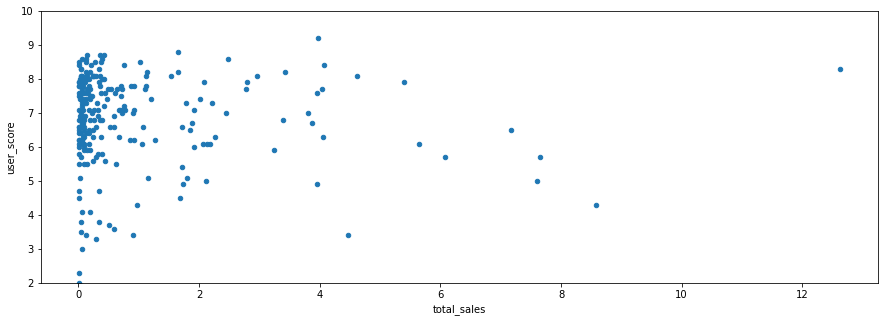

In [26]:
(
    games_2015[games_2015['platform'] == 'PS4']
    .plot(kind='scatter', x='total_sales', y='user_score', ylim=(2, 10), figsize=(15, 5))
);

На графике корреляции можно проследить, зависимость кол-ва продаж относительно оценки пользователей. Если не брать выбросы около оценки 4 и 6, можно сказать, чем выше оценка тем больше высоких показателей продаж, но корреляция сложно просматриваться. Могу предположить, что это связанно с недостатком данных.

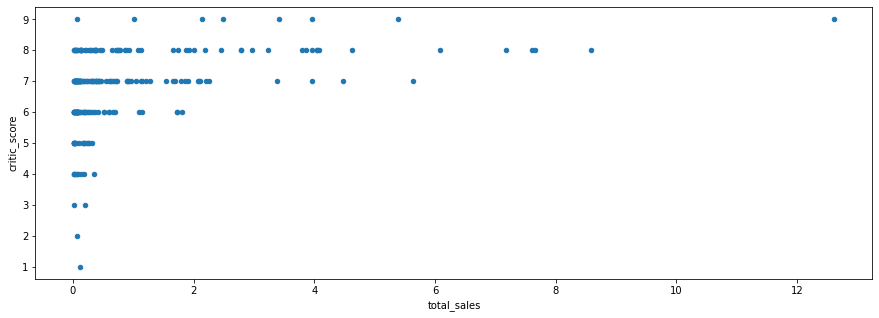

In [27]:
(
    games_2015[(games_2015['platform'] == 'PS4') & (games_2015['critic_score'] != 0)]
    .plot(kind='scatter', x='total_sales', y='critic_score', figsize=(15, 5))
);

По графику можно сказать, что между оценками критиков и продажами, корреляция более явная, чем с пользователями. Два графика имеют много сходств, но критики оценивают игры выше, с высокими показателями продаж, по сравнению с обычными пользователи.

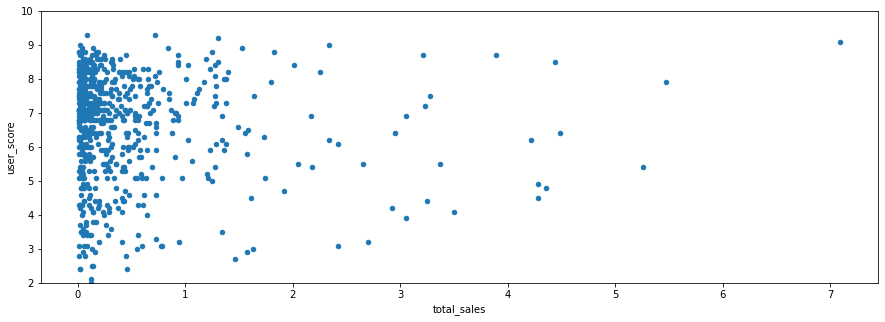

In [28]:
(
    games_2015[games_2015['platform'] != 'PS4']
    .plot(kind='scatter', x='total_sales', y='user_score', ylim=(2, 10), figsize=(15, 5))
);

Соотношение продаж и оценки пользователе более хаотичное на других платформах, корреляция менее явная, по сравнению с PS4. Основной диапазон оценки от 5 до 9. Можно предположить, что люди при оценивании не сильно задумываются и если игра нравится, ставят больше 5(хаотично).

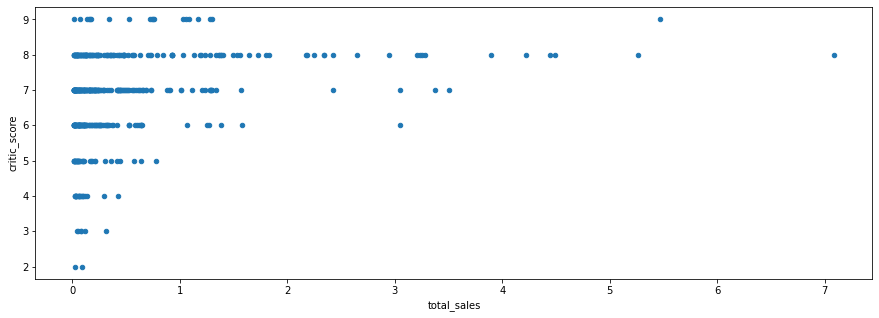

In [29]:
(
    games_2015[(games_2015['platform'] != 'PS4') & (games_2015['critic_score'] != 0)]
    .plot(kind='scatter', x='total_sales', y='critic_score', figsize=(15, 5))
);

Картина с критиками похожа на PS4. Чем выше оценка критика, тем больше продаж у игры. Интересный факт, что у кассовых игр более частая оценка равна 8(как и на PS4).

#### Теперь, рассмотрим как распределены показатели продаж по жанрам.

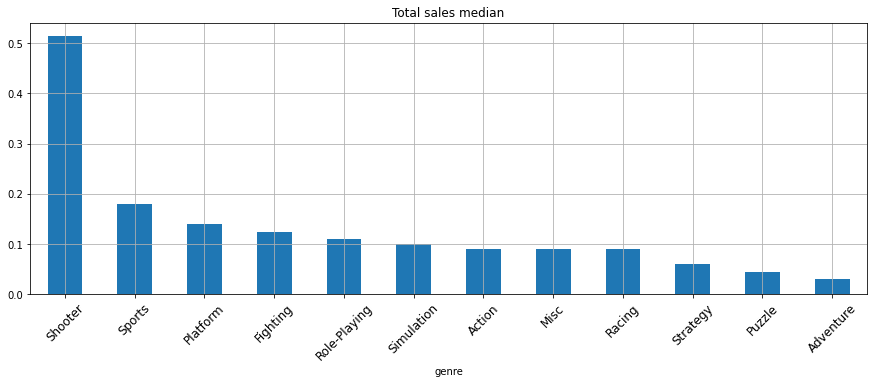

In [30]:
(
    games_2015.pivot_table(
        index='genre',
        values='total_sales',
        aggfunc='median'
    )
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar', figsize=(15, 5), grid=True, legend=False, title='Total sales median')
)
plt.xticks(rotation=45, fontsize=12)
plt.show()

На графике, отчетливо видно, что самые успешные игры в жанре Shooter. И между первым и вторым местом очень существенный разрыв(чуть меньше 0.8 млн). Разница между 2-ой и 12-ой позицией спаска ~1.5 млн. Не большое отличие, по сравнению с первым и вторым местом. Можно еще выделить 2 и 3 место, Simulation и Misc соответственно. У этих жанров хорошие показатели, если не учитывать первое место.

## Портрет пользователя

Рассмотрим закономерности и интересные особенности трех разных рынков (Америка, Европа, Япония).

### Сравним продажи по платформам

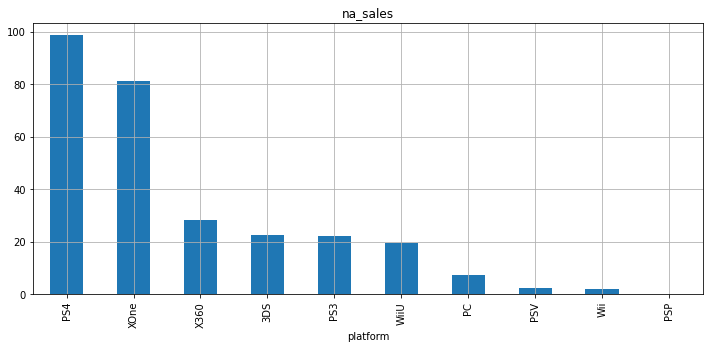

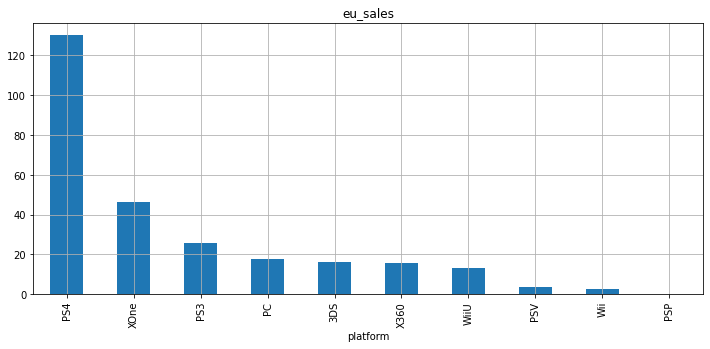

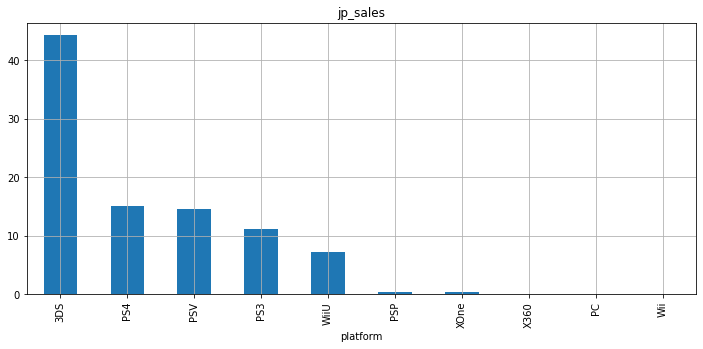

In [31]:
for i, region in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    (
        games_2015.pivot_table(
            index='platform',
            values=region,
            aggfunc='sum'
        )
        .sort_values(by=region, ascending=False)
        .plot(kind='bar', figsize=(12, 5), grid=True, legend=False)
    )
    plt.title(region)
    plt.show()

На графиках мы можем наблюдать, что самые популярные платформы PS4 и Xbox One, но только не для Японского рынка. В Японии самая популярная консоль - 3DS, на втором месте PS4, а Xbox даже в топ-5 не попал. Но самих продажи в японии мало по сравнению с Европой и Америкой. Также, мы видим, что в Америке доля продаж для PS4 и Xbox One практически одинаковая, а в Европе PS4 сильно выигрывает по кол-во продаж.

### Сравним продажи по жанрам

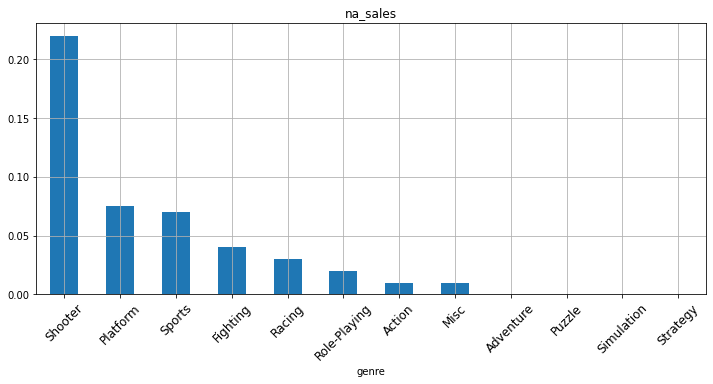

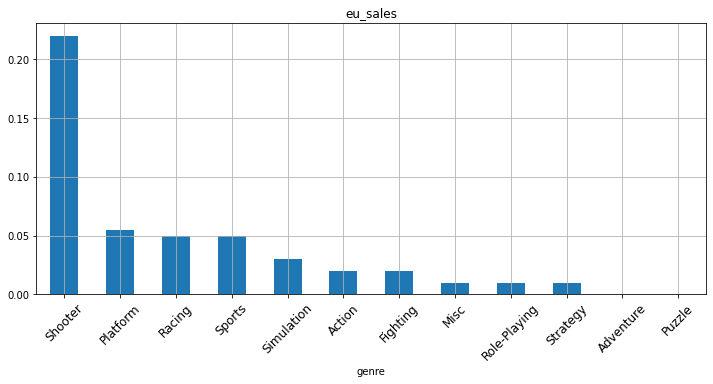

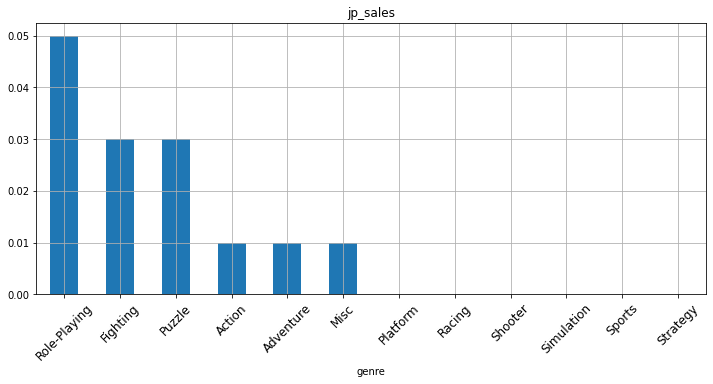

In [32]:
for i, region in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    (
        games_2015.pivot_table(
            index='genre',
            values=region,
            aggfunc='median'
        )
        .sort_values(by=region, ascending=False)
        .plot(kind='bar', figsize=(12, 5), grid=True, legend=False)
    )
    plt.xticks(rotation=45, fontsize=12)
    plt.title(region)
    plt.show()

Также, как и с платформами, ситуация на рыках Европы и Америки схожи. Но несколько факторов можно отметить:
- В Европе одинаково популярны жанры Shooter и Action. На Американском рынке выигрывает Shooter(разница около 7 млн с вторым местом).
- Европейские геймеры больше предпочитают гонки, а Америке в топ-5 входит жанр Fighting.

На Японском рынке сильно преобладать жанр Action. Разница со втором место больше половины. И еще одна особенность: жанр Simulation входит в топ-5.
Все остальные жанры и места примерно схожи на всех рынках.

### Сравним, как влияет возрастной рейтинг на продажи

In [33]:
games_2015['rating'] = games_2015['rating'].fillna('unknown')

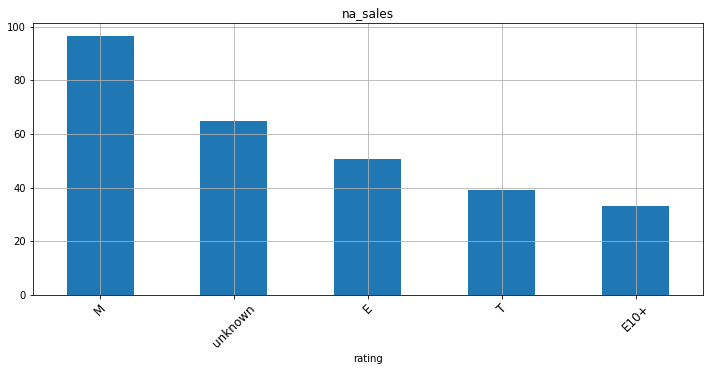

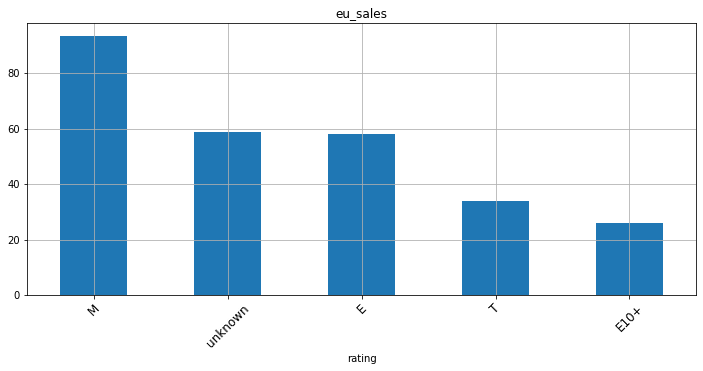

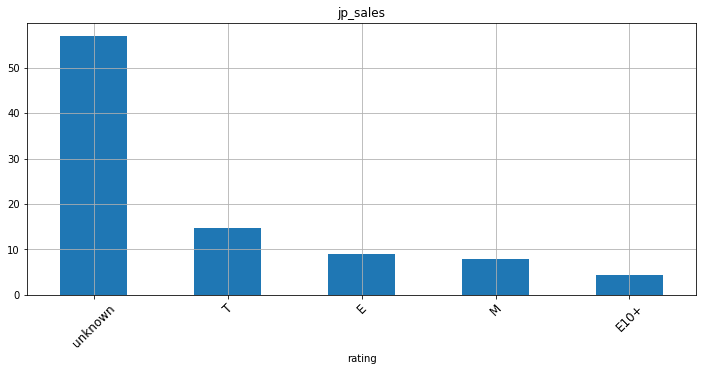

In [34]:
for i, region in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    (
        games_2015.pivot_table(
            index='rating',
            values=region,
            aggfunc='sum'
        )
        .sort_values(by=region, ascending=False)
        .plot(kind='bar', figsize=(12, 5), grid=True, legend=False)
    )
    plt.xticks(rotation=45, fontsize=12)
    plt.title(region)
    plt.show()

Как и в прошлых наблюдениях, рынки Америки и Европы схожи. Есть только не большое различие между продажами игр для детей и подростков, но они не значительные. Процентно доли тоже совпадают.
На Японском рынке картина другая. Преобладающая часть игр без рейтинга. Есть предположения, что это связанно с кол-вом игр, выпускаемых без международного возрастного рейтинга. Это могут быть игры только для Японского рынка. Либо на каких-то консолях этого рейтинга нет. В любом случае этот факт нужно учитывать при запуске рекламной компании.

## Проверка гипотез

### Первая гипотеза.

alpha возьмем стандартное - 5%. Выборки не большие, поэтому будет ошибкой брать alpha = 1%. p-значение может сильно исказится из-за недостатка значений в выборке.
Нулевая гипотеза будет формироваться исходя из равенства двух выборок, а альтернативная из неравенства.
Критерий оценки: Если уровень p-уровень значимости меньшее альфа, то отвергаем нулевую гипотезу. Если же альфа больше, то принимаем нулевую гипотезу.

- Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC отличаются.

In [35]:
results = st.ttest_ind(
    games_2015[games_2015['platform'] == 'XOne']['user_score'].dropna().astype(float),
    games_2015[games_2015['platform'] == 'PC']['user_score'].dropna().astype(float)
)

print('p-значение: ', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')

else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение:  0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


Полученный вывод говорит о том, что пользовательские оценки не сильно отличаются, в зависимости от платформы. Пользователь оценивают игру, а не платформу.

### Вторая гипотеза.

alpha возьмем стандартное - 5%. Выборки не большие, поэтому будет ошибкой брать alpha = 1%. p-значение может сильно исказится из-за недостатка значений в выборке.
Нулевая гипотеза будет формироваться исходя из равенста двух выборок, а альтернативная из неравенства.
Критерий оценки: Если уровень p-уровень значимости меньше альфа, то отвергаем нулевую гипотезу. Если же альфа больше, то принимаем нулевую гипотезу.

- Нулевая гипотеза: cредние пользовательские рейтинги жанров Action и Sports одиноковые.
- Альтернативная гипотеза: cредние пользовательские рейтинги жанров Action и Sports различны.

In [36]:
results = st.ttest_ind(
    games_2015[games_2015['genre'] == 'Action']['user_score'].dropna().astype(float),
    games_2015[games_2015['genre'] == 'Sports']['user_score'].dropna().astype(float)
)

print('p-значение: ', results.pvalue)

if results.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу')

else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение:  2.8711147985105864e-19
Отвергаем нулевую гипотезу


На основе полученных данные, мы можем сделать вывод, что оценки пользователей жанров Action и Sports действительно разные. И мы отвергаем нулевую гипотезу.

# Вывод

*Данные взята за 2014 - 2016 года.*

В ходе проведения исследования, были было обнаружено несколько факторов, которые могут повлиять на рекламную компанию:
1. **Глобальные показатели:**
    1. Самая популярная платформы по кол-ву продаж - **PS4** (**280 млн продаж** за 3 неполных года). Для сравнения, **Xbox One** (второе место по продажам) имеет этот показатель на уровне **140 млн**. На третьем месте -  **Nintendo 3DS** (**90 млн продаж**).
    2. Средний диапазон продаж игр у PS4, не сильно больше Xbox One. Но на конечную цифру (**280 млн**), сильно **влияют эксклюзивы** (игры, которые выходят только для PS4). Это основное отличие двух платформ PS4 и Xbox One. 
    3. На продажи оценки пользователей влияют не сильно, что не скажешь про оценки критиков. Корреляция между высокой оценкой критика и кол-вом продаж более существенная. Для достижения **высоких показателей продаж**, игре желательно получать **хорошие отзывы от критиков**.
    4. **Shooter** - самые продаваемые жанр. **Среднее** число продаж для игр в этом жанре - **0.5 млн**. На **втором месте** жанр **Sports** - **0.18 млн продаж**. Остальные жанры не сильно отличаются друг от друга кол-вом продаж. 
    5. Тип платформы не влияет на пользовательские оценки игры.

2. **Для рынка Америки и Европы:**
    1. **Популярность PS4** в Америке и Европе практически **одинаковая**. В **Европе - 126 млн**. В **Америке - 100 млн**.  В процентном соотношение разница не большая. **Кол-во продаж на PS4** в **Европе** **больше**, числа продаж в Америке **на 26%**.  
    2. **Кол-во продаж** на **Xbox One** в **Америке** на **172% больше**, по сравнению с Европой. **82 млн продаж в Амрике**,  против **46 млн в Европе**.
    3. **Популярность жанров** и процентном соотношение, **схожи с глобальными** показателями. Первое место (**Shooter**) - **0.23 млн**. **Второе место** - **0.07 млн**. 
    4. **Самые продаваем** игры имеют возрастной рейтинг M (**от 17 лет**). Это коррелируется с самым продаваемым жанром - Shooter. Так же, эксклюзивы Sony часто имеют такой рейтинг. На втором месте игры без рейтинга ESRB. 
    
3. Для Японского рынка(третий по кол-ву продаж):
    1. **Японский рынок самобытный** и сильно отличатся от глобального.
    2. Самая популярная платформа - **Nintendo 3DS** (**47 млн продаж**). **Второе место** разделили две консоли Sony (**PS4, PSV**). Японцам больше предпочитают **портативные платформы**. Есть предположение, что это связанно с их образом жизни. Играют пока, добираются с работы до дома и обратно. Но PS4 для прохождения новинок Sony все же имеют, хоть это не основная их консоль. 
    3. Самые популярный жанр - **Role-playing** (**0.05 млн** продаж). На втором месте, Fighting и Puzzle. 
    4. Самые популярный жанр - Shooter, в Японии практически не имеет популярности. Можно предположить, что это связанно с их менталитетом и негативным отношением к оружию. 
    5. Самые популярные игры не имеют возрастного рейтинга ESRB. На втором месте игры с рейтингом T (от 13 лет).
